This is an example of a jupyter notebook, running using the `pixi` environment we created to manage our dependencies. Note that you may need to change your python interpreter (top right corner) to:
`.pixi/envs/default/bin/python`

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import random
import torch
import sklearn

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import roc_auc_score
from opensoundscape.ml import bioacoustics_model_zoo as bmz
from opensoundscape.ml.shallow_classifier import quick_fit 

Pre-processing

In [2]:
datapath = "/workspaces/non-avian-ml-toy/data/audio"
species = "bullfrog"
datatype = "data"

files = glob.glob(os.path.join(datapath, species, datatype, "**/*.wav"), recursive=True)
labels = pd.DataFrame({"file": files, "present": ["pos" in f.lower() for f in files]})

# Do this step ONLY to convert to 5 second dataset to run perch!!!!
labels['file'] = labels['file'].apply(lambda x: re.sub(r'data', 'data_5s', x, count=2).replace('data_5s', 'data', 1)) 

labels['file'] = labels['file'].astype(str)
labels.set_index("file", inplace=True)

pd.set_option('display.max_colwidth', 100)
print(labels.head())

                                                                                              present
file                                                                                                 
/workspaces/non-avian-ml-toy/data/audio/bullfrog/data_5s/pos/bullfrog-pos-t-11113588_145.wav     True
/workspaces/non-avian-ml-toy/data/audio/bullfrog/data_5s/pos/bullfrog-pos-t-11113588_147.wav     True
/workspaces/non-avian-ml-toy/data/audio/bullfrog/data_5s/pos/bullfrog-pos-t-11113588_151.wav     True
/workspaces/non-avian-ml-toy/data/audio/bullfrog/data_5s/pos/bullfrog-pos-t-11113588_150.wav     True
/workspaces/non-avian-ml-toy/data/audio/bullfrog/data_5s/pos/bullfrog-pos-t-11113588_155.wav     True


In [3]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[['present']])

Run Models

In [4]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo', "Perch", trust_repo=True)

Downloading: "https://github.com/kitzeslab/bioacoustics-model-zoo/zipball/main" to /root/.cache/torch/hub/main.zip
2025-04-01 21:41:57.806806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 21:41:58.596163: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-01 21:41:58.596213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-01 21:41:58.616512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 21:41:58.911917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is opti

In [6]:
emb_train = model.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = model.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

model.change_classes(['present'])

/workspaces/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:341: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/workspaces/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:341: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clips[label_df.columns] = label_df.loc[f]
/workspaces/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/opensoundscape/utils.py:341: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

  0%|          | 0/1 [00:00<?, ?it/s]

2025-04-01 21:42:42.057264: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6382564cdcf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-01 21:42:42.057306: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-01 21:42:42.451750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-01 21:42:42.493005: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-04-01 21:42:44.864134: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-01 21:42:44.873997: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2025-04

  0%|          | 0/1 [00:00<?, ?it/s]

2025-04-01 21:43:02.083755: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-04-01 21:43:04.463823: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 123418624 exceeds 10% of free system memory.


In the prior step is where the kernel crashes while embedding, apparently could be caused by a package installation issue with tensorflow or numpy (https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes) 

Error: "The Kernel crashed while executing code in the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure."

In [7]:
quick_fit(model.network, emb_train, labels_train.values, emb_val, labels_val.values, steps=1000)

Epoch 100/1000, Loss: 0.1806381493806839, Val Loss: 0.3862502872943878
val AU ROC: 0.867
val MAP: 0.867
Epoch 200/1000, Loss: 0.08108565211296082, Val Loss: 0.2845730185508728
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.04675358533859253, Val Loss: 0.24748168885707855
val AU ROC: 1.000
val MAP: 1.000
Epoch 400/1000, Loss: 0.030863599851727486, Val Loss: 0.23111090064048767
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.022115126252174377, Val Loss: 0.2232300192117691
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.01673259027302265, Val Loss: 0.21945105493068695
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.013157716952264309, Val Loss: 0.21788083016872406
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.010647459886968136, Val Loss: 0.2175912857055664
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.00880866963416338, Val Loss: 0.21808409690856934
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.007416342385113239, Va

In [8]:
predictions = model.network(torch.tensor(emb_val).float()).detach().numpy()
score = roc_auc_score(labels_val.values, predictions, average=None)

print(score)

1.0


/workspaces/non-avian-ml-toy/.pixi/envs/default/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


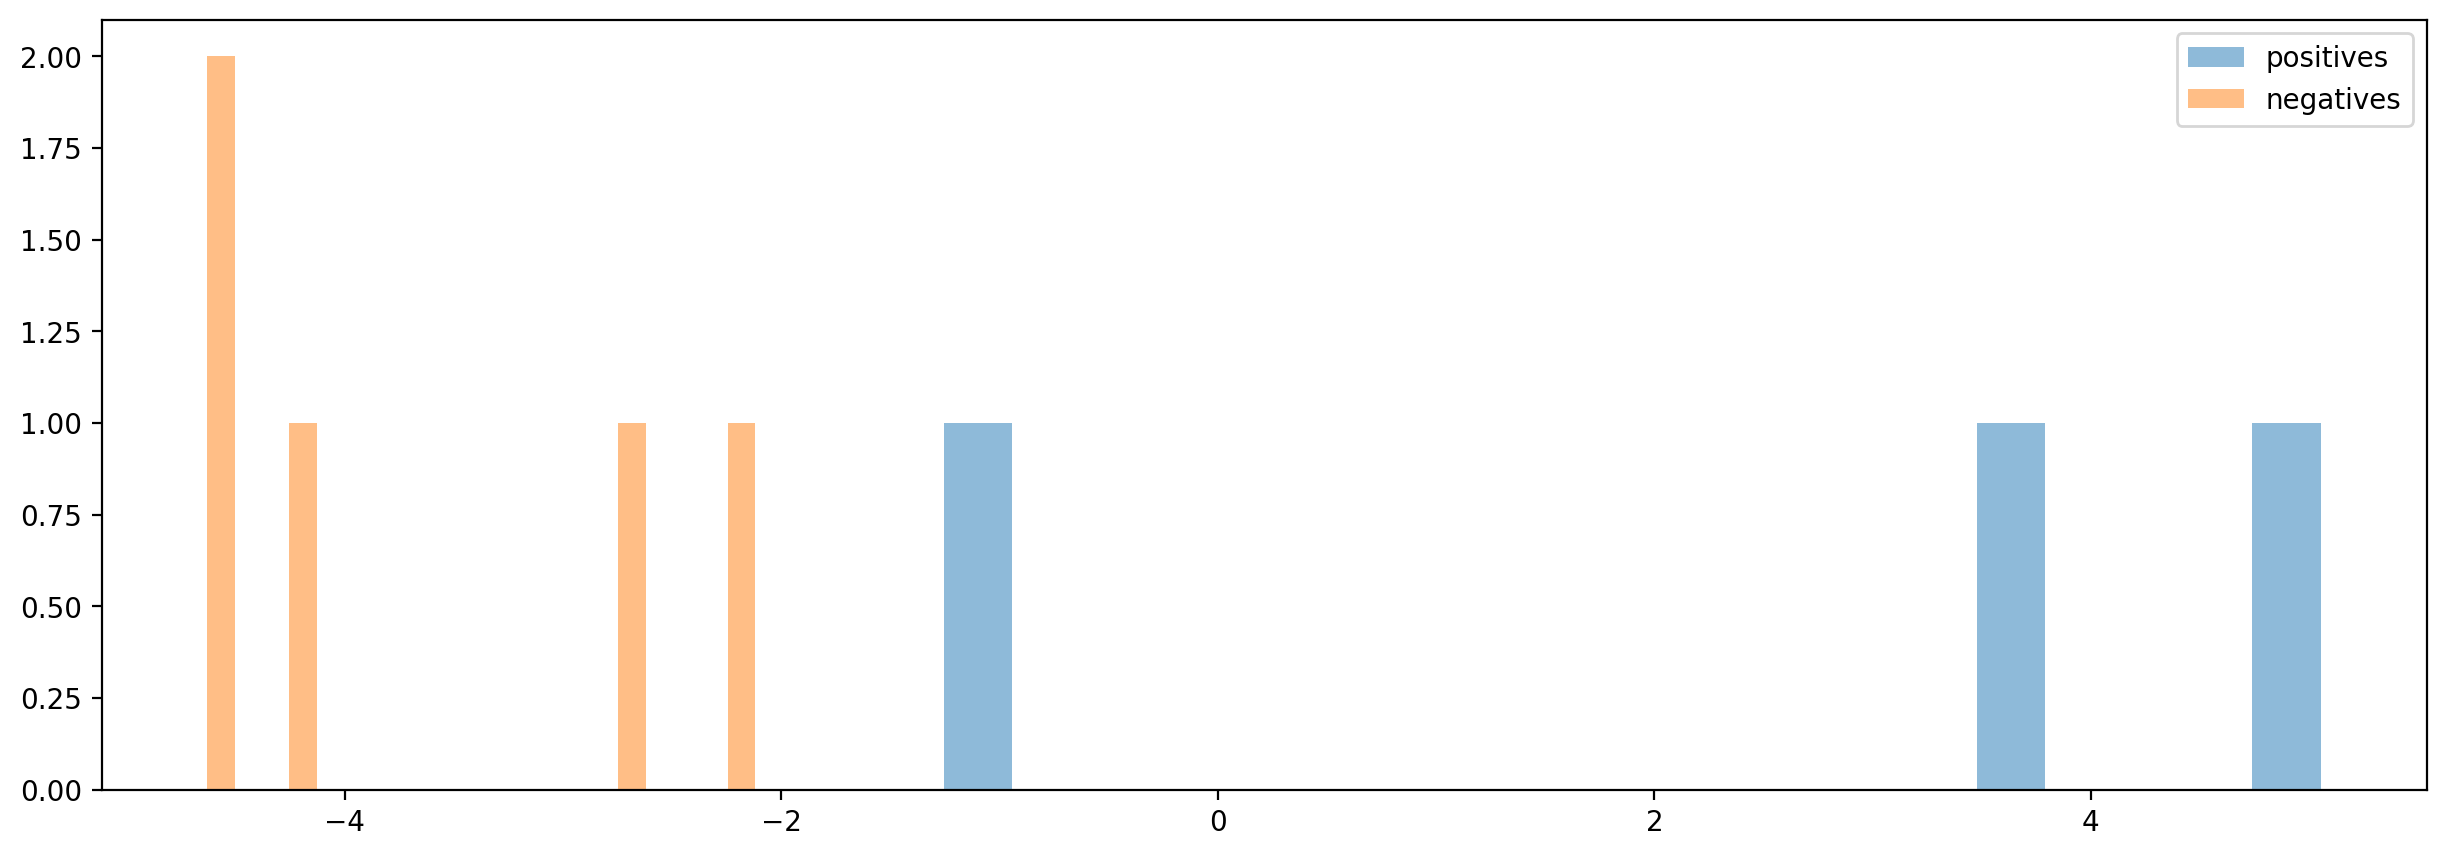

: 

In [ ]:
plt.hist(predictions[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(predictions[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()